In [41]:
IOU_THRES = 0.6
NC = 8
CONF_STEPS = 1001
class_names = ['black sheep', 'brown sheep', 'grey sheep', 'white sheep','black occluded sheep', 'brown occluded sheep', 'grey occluded sheep', 'white occluded sheep']

model = "Baseline-n"

In [42]:
def parseLabel(label: str) -> dict:
    values = label.split()
    dict = {}
    dict["class"] = int(values[0])
    if len(values) > 5:
        dict["conf"] = float(values[5])
    
    xc = float(values[1])
    yc = float(values[2])
    width = float(values[3])
    height = float(values[4])

    dict["x1"] = xc - width
    dict["x2"] = xc + width
    dict["y1"] = yc - height
    dict["y2"] = yc + height

    return dict

def iou(l1: dict, l2: dict):
    x1 = max(l1["x1"], l2["x1"])
    x2 = min(l1["x2"], l2["x2"])
    y1 = max(l1["y1"], l2["y1"])
    y2 = min(l1["y2"], l2["y2"])

    if x2 - x1 <= 0 or y2 - y1 <= 0:
        return 0
    
    ia = (x2 - x1) * (y2 - y1)
    l1a = (l1["x2"] - l1["x1"]) * (l1["y2"] - l1["y1"])
    l2a = (l2["x2"] - l2["x1"]) * (l2["y2"] - l2["y1"])

    ua = l1a + l2a - ia

    return ia / ua

In [43]:
import os
import numpy as np

testLabelDir = f"tests/{model}/labels"
groundTruthLabelDir = f"dataset/labels"

testLabelFiles = list(filter(lambda x: x.endswith("txt"),os.listdir(testLabelDir)))

conf_thresholds = np.linspace(0, 1, CONF_STEPS)

true_positives = np.zeros((NC, len(conf_thresholds)))
false_positives = np.zeros((len(conf_thresholds)))
false_negatives = np.zeros((NC, len(conf_thresholds)))

instance_count = np.zeros((NC))
image_count = len(testLabelFiles)

for labelFile in testLabelFiles:

    with open(f"{groundTruthLabelDir}/{labelFile}") as gFile, open(f"{testLabelDir}/{labelFile}") as tFile:
        gLabels = gFile.readlines()
        tLabels = tFile.readlines()
    
    gBoxes = [parseLabel(label) for label in gLabels]
    proposalBoxes = [parseLabel(label) for label in tLabels]
    tBoxes = []

    for gBox in gBoxes:
        instance_count[gBox["class"]] += 1

    # NMS
    while(len(proposalBoxes) > 0):
        currentBox = proposalBoxes.pop(0)
        tBoxes.append(currentBox)
        for (i, proposalBox) in enumerate(proposalBoxes):
            if iou(currentBox, proposalBox) > IOU_THRES:
                proposalBoxes.pop(i)

    for tBox in tBoxes:
        tp = False
        for (i, gBox) in enumerate(gBoxes):
            if iou(tBox, gBox) > IOU_THRES:
                tp = True

                for (j, conf_threshold) in enumerate(conf_thresholds):
                    if (tBox["conf"] >= conf_threshold):
                        true_positives[gBox["class"]][j] += 1

                    if (conf_threshold > tBox["conf"]):
                        false_negatives[gBox["class"]][j] += 1

                gBoxes.pop(i)
                break
        
        if not tp:
            for (j, conf_threshold) in enumerate(conf_thresholds):
                if (tBox["conf"] >= conf_threshold):
                    false_positives[j] += 1
    
    for (j, conf_threshold) in enumerate(conf_thresholds):
        for gBox in gBoxes:
            false_negatives[gBox["class"]][j] += 1
    



In [44]:
for c, name in enumerate(class_names):
    print(name, true_positives[c][10] / instance_count[c])

black sheep 0.9642857142857143
brown sheep 0.9753086419753086
grey sheep 0.977859778597786
white sheep 0.9915119363395225
black occluded sheep 0.5
brown occluded sheep 1.0
grey occluded sheep 0.6129032258064516
white occluded sheep 0.8260869565217391


Text(0, 0.5, 'Recall')

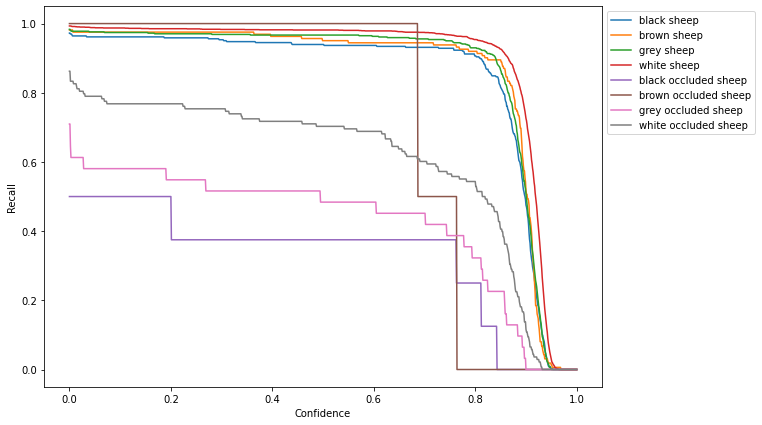

In [69]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,7)

for c in range(NC):
    plt.plot(conf_thresholds, true_positives[c]/instance_count[c], label=class_names[c])

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")

Text(0, 0.5, 'Recall')

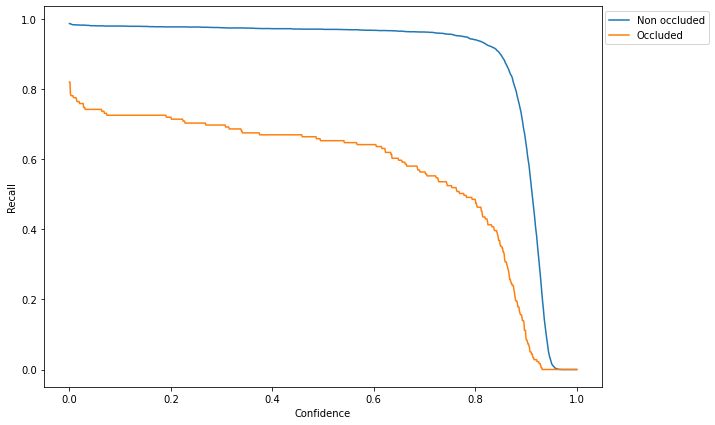

In [66]:
nonoccluded = true_positives[:4, :].sum(axis=0) / instance_count[:4].sum()
occluded = true_positives[4:, :].sum(axis=0) / instance_count[4:].sum()

plt.plot(conf_thresholds, nonoccluded, label="Non occluded")
plt.plot(conf_thresholds, occluded, label="Occluded")

plt.legend(bbox_to_anchor=(1.2,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")

Text(0, 0.5, 'Recall')

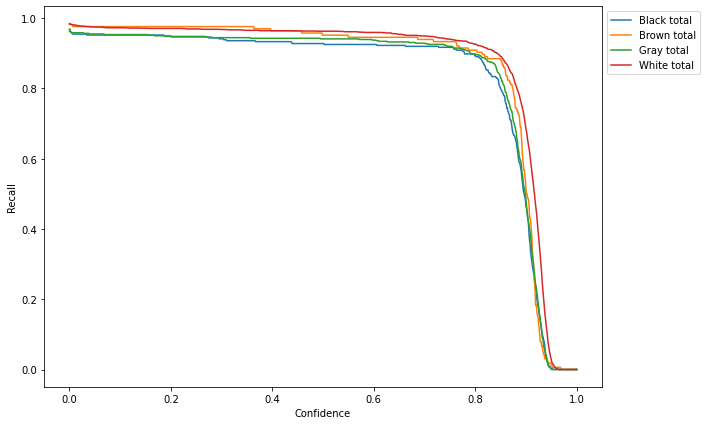

In [60]:
black = true_positives[[0,4], :].sum(axis=0) / instance_count[[0,4]].sum()
brown = true_positives[[1,5], :].sum(axis=0) / instance_count[[1,5]].sum()
gray = true_positives[[2,6], :].sum(axis=0) / instance_count[[2,6]].sum()
white = true_positives[[3,7], :].sum(axis=0) / instance_count[[3,7]].sum()

plt.plot(conf_thresholds, black, label="Black total")
plt.plot(conf_thresholds, brown, label="Brown total")
plt.plot(conf_thresholds, gray, label="Gray total")
plt.plot(conf_thresholds, white, label="White total")

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")

Text(0, 0.5, 'Recall')

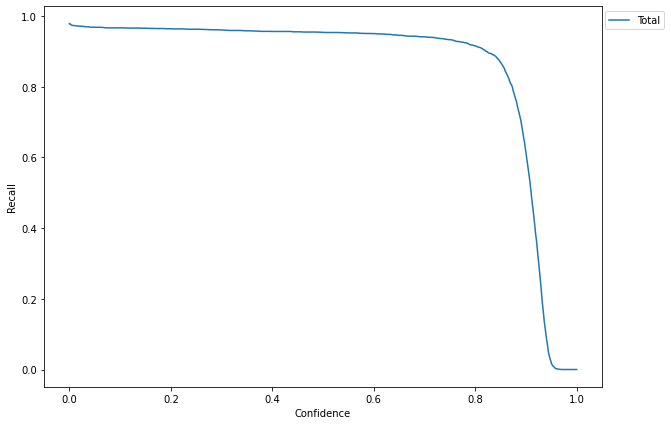

In [75]:
plt.plot(conf_thresholds, true_positives.sum(axis=0) / instance_count.sum(), label="Total")
plt.legend(bbox_to_anchor=(1.12,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")

Text(0, 0.5, 'Recall')

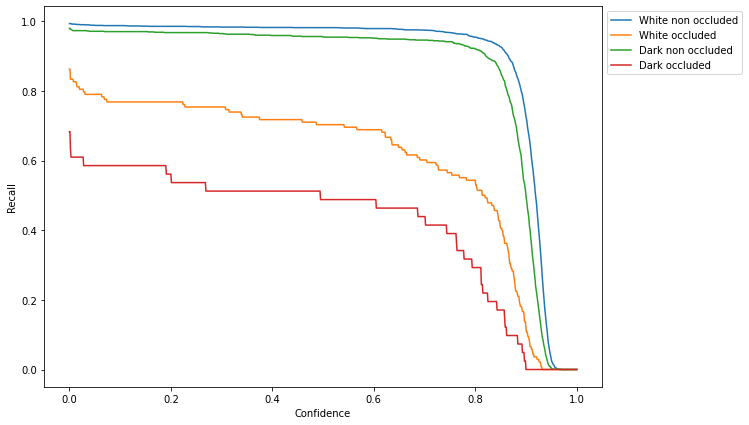

In [62]:
white_non_occ = true_positives[3] / instance_count[3]
white_occ = true_positives[7] / instance_count[7]

dark_non_occ = true_positives[:3].sum(axis=0) / instance_count[:3].sum()
dark_occ = true_positives[4:7].sum(axis=0) / instance_count[4:7].sum()

plt.plot(conf_thresholds, white_non_occ, label="White non occluded")
plt.plot(conf_thresholds, white_occ, label="White occluded")
plt.plot(conf_thresholds, dark_non_occ, label="Dark non occluded")
plt.plot(conf_thresholds, dark_occ, label="Dark occluded")

plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel("Confidence")
plt.ylabel("Recall")